# Setup and Algorithms

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_dir = '/content/drive/MyDrive/ODSP_Experiments'

In [ ]:
def f(x):
    return 1 + np.sin(2*x)

In [ ]:
import numpy as np

def generate_fixed_theta_and_contexts(K, d):
    """
    Generates K context vectors in R^d with the first arm X_1 being optimal,
    X_2 being suboptimal, and the rest X_3 to X_K within a ball of radius 1
    and satisfying the condition X_i^\top theta < 1/2.

    Parameters:
    K (int): Number of context vectors.
    d (int): Dimension of the context vectors.

    Returns:
    contexts (np.ndarray): Generated context vectors (K x d).
    theta (np.ndarray): Fixed theta vector (d,).
    """

    # Step 1: Set theta = (1, 0, ..., 0)
    theta = np.zeros(d)
    theta[0] = 1

    # Step 2: Set X_1 = (1, 0, ..., 0) (optimal arm)
    X_1 = np.zeros(d)
    X_1[0] = 1

    # Step 3: Set X_2 = (1/2, 0, ..., 0) (suboptimal arm)
    X_2 = np.zeros(d)
    X_2[0] = 1/2

    # Step 4: Generate X_3, ..., X_K within a ball of radius 1 and satisfying X_i^\top theta < 1/2
    contexts = [X_1, X_2]

    for _ in range(K - 2):
        while True:
            # Generate a random point inside the unit ball
            X_i = np.random.randn(d)
            X_i /= np.linalg.norm(X_i)
            # X_i *= np.random.uniform(0, 1)  # Scale to ensure it's within the ball of radius 1

            # Check if X_i satisfies X_i^\top theta < 1/2
            if X_i.dot(theta) < 1/2:
                contexts.append(X_i)
                break

    return np.array(contexts), theta


import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Set the output directory
os.makedirs(output_dir, exist_ok=True)

def leverage_score(X, p, reg=1e-3):
    P = np.diag(p)
    M = X.T @ P @ X + reg * np.eye(X.shape[1])
    M_inv = np.linalg.inv(M)
    return np.array([X[i] @ M_inv @ X[i].T for i in range(X.shape[0])])

def g_optimal_design(X):
    K, d = X.shape

    def objective(p):
        return np.max(leverage_score(X, p))

    constraints = (
        {'type': 'eq', 'fun': lambda p: np.sum(p) - 1},  # sum of probabilities is 1
        {'type': 'ineq', 'fun': lambda p: p}  # probabilities are non-negative
    )
    p0 = np.ones(K) / K  # initial guess
    result = minimize(objective, p0, constraints=constraints, bounds=[(0, 1)] * K, method='SLSQP')

    if result.success:
        return result.x
    else:
        raise ValueError("G-optimal design did not converge")

def DEO(X):
    K, d = X.shape

    # Step 1: Calculate b_2, ..., b_K where b_i = X_i - X_1
    b = np.array([X[i] - X[0] for i in range(1, K)])

    # Step 2: Find the G-optimal design \tilde{p}_2, ..., \tilde{p}_K for b_2, ..., b_K
    p_tilde = g_optimal_design(b)

    # Step 3: Set p_1 = 1/2, p_i = \tilde{p}_i / 2 for i = 2, ..., K
    p = np.zeros(K)
    p[0] = 0.5  # p_1 = 1/2
    p[1:] = p_tilde / 2  # p_i = \tilde{p}_i / 2 for i = 2, ..., K

    # Return the policy \pi = (p_1, ..., p_K)
    return p


def random_points_on_sphere(K, d):
    vec = np.random.randn(K, d)
    vec /= np.linalg.norm(vec, axis=1)[:, np.newaxis]
    return vec



def random_points_on_sphere(K, d):
    vec = np.random.randn(K, d)
    vec /= np.linalg.norm(vec, axis=1)[:, np.newaxis]
    return vec

## Ours (SBE)

In [ ]:
def leverage_score(X, p, reg=1e-3):
    P = np.diag(p)
    M = X.T @ P @ X + reg * np.eye(X.shape[1])
    M_inv = np.linalg.inv(M)
    return np.array([X[i] @ M_inv @ X[i].T for i in range(X.shape[0])])

def g_optimal_design(X):
    K, d = X.shape

    def objective(p):
        return np.max(leverage_score(X, p))

    constraints = (
        {'type': 'eq', 'fun': lambda p: np.sum(p) - 1},  # sum of probabilities is 1
        {'type': 'ineq', 'fun': lambda p: p}  # probabilities are non-negative
    )
    p0 = np.ones(K) / K  # initial guess
    result = minimize(objective, p0, constraints=constraints, bounds=[(0, 1)] * K, method='SLSQP')

    if result.success:
        return result.x
    else:
        raise ValueError("G-optimal design did not converge")

def DEO(X):
    K, d = X.shape

    # Step 1: Calculate b_2, ..., b_K where b_i = X_i - X_1
    b = np.array([X[i] - X[0] for i in range(1, K)])

    # Step 2: Find the G-optimal design \tilde{p}_2, ..., \tilde{p}_K for b_2, ..., b_K
    p_tilde = g_optimal_design(b)

    # Step 3: Set p_1 = 1/2, p_i = \tilde{p}_i / 2 for i = 2, ..., K
    p = np.zeros(K)
    p[0] = 0.5  # p_1 = 1/2
    p[1:] = p_tilde / 2  # p_i = \tilde{p}_i / 2 for i = 2, ..., K

    # Normalize p to ensure it sums to 1
    p /= np.sum(p)

    # Return the policy \pi = (p_1, ..., p_K)
    return p


def SBE(X, theta_star, sigma, delta, T):
    K, d = X.shape
    cumulative_regret = []
    total_regret = 0
    num_pulls = 0
    optimal_arm = None  # Initialize optimal_arm

    A = list(range(K))
    l = 1  # Start from 1 to avoid log(0)

    # X_samples = []
    # y_samples = []

    while num_pulls < T:
        if len(A) > 1:
            epsilon_l = 1 / (2 ** l)
            pi_l = DEO(X[A])
            n_l = int(min(int(np.ceil(hyper  *(np.log(d/epsilon_l) + np.log(l/delta) +np.log(K*l) ) / epsilon_l**2 * d )
            + hyper_2 *d**(3/2)/epsilon_l *np.log(d*K*l/delta)),int(np.ceil(hyper*d*d*np.log(d*l/(epsilon_l*delta))/epsilon_l**2)) ))+ 1
            X_samples = []
            y_samples = []

            for _ in range(n_l):
                if num_pulls >= T:
                    break
                i = np.random.choice(A, p=pi_l)
                reward = X[i].dot(theta_star) + np.random.normal(0, sigma) + f(num_pulls)

                # Calculate X_mean and center the context
                X_mean = np.sum([pi_l[j] * X[A[j]] for j in range(len(A))], axis=0)
                X_centered = X[i] - X_mean

                X_samples.append(X_centered)
                y_samples.append(reward)

                # Update cumulative regret
                total_regret += max(X.dot(theta_star)) - X[i].dot(theta_star)
                cumulative_regret.append(total_regret)

                num_pulls += 1

            X_samples_array = np.array(X_samples)
            y_samples_array = np.array(y_samples)
            # Perform ridge regression with centered design matrix
            V = X_samples_array.T @ X_samples_array + np.log(n_l/delta) * np.eye(d)
            b = X_samples_array.T @ y_samples_array
            theta_hat = np.linalg.solve(V, b)

            to_eliminate = []
            for i in A:
                if max(X[A].dot(theta_hat)) - X[i].dot(theta_hat) > 1*epsilon_l:
                    to_eliminate.append(i)

            A = [i for i in A if i not in to_eliminate]
            l += 1
        else:
            while num_pulls < T:
                i = A[0]
                reward = X[i].dot(theta_star) + np.random.normal(0, sigma) + f(num_pulls)
                total_regret += max(X.dot(theta_star)) - X[i].dot(theta_star)
                cumulative_regret.append(total_regret)
                num_pulls += 1
            optimal_arm = A[0]
            break

    # Handle case where optimal_arm is not set due to all arms being eliminated
    if optimal_arm is None and len(A) == 1:
        optimal_arm = A[0]

    return optimal_arm, cumulative_regret, num_pulls

## Semipara-TS

In [ ]:
epsilon = 1e-6  # Small positive value to prevent singularity

def ts_algorithm(X, theta_star, sigma, delta, T, num_samples=2000, nu_values=[1,2]):
    K, d = X.shape
    best_nu = None
    best_cumulative_regret = None
    best_num_pulls = None

    # Iterate over different nu values to perform model selection
    for nu in nu_values:
        print(f"Trying nu = {nu}")
        cumulative_regret = []
        total_regret = 0
        num_pulls = 0

        # Initialize
        R = 1
        B = np.eye(d)  # d x d identity matrix
        y = np.zeros(d)  # zero vector of size d
        v = nu * np.sqrt(d* np.log(T/delta))  # Use nu as the variance parameter

        for t in range(1, T + 1):
            # Compute mu_hat(t)
            try:
                B_inv = np.linalg.inv(B + epsilon * np.eye(d))  # Adding regularization for stability
            except np.linalg.LinAlgError:
                print("Matrix inversion failed at time step:", t)
                break

            mu_hat = B_inv @ y

            # Sample mu_tilda(t) from N(mu_hat(t), v^2 B^-1)
            mu_tilda = np.random.multivariate_normal(mu_hat, v**2 * B_inv)

            # Pull arm a_t = argmax b_i(t)^T mu_tilda
            a_t = np.argmax([X[i].dot(mu_tilda) for i in range(K)])
            reward = X[a_t].dot(theta_star) + np.random.normal(0, sigma) + f(num_pulls)

            # Update regret
            total_regret += max(X.dot(theta_star)) - X[a_t].dot(theta_star)
            cumulative_regret.append(total_regret)

            # Vectorized Sampling: generate num_samples samples at once
            mu_tilda_samples = np.random.multivariate_normal(mu_hat, v**2 * B_inv, size=num_samples)  # shape (num_samples, d)

            # Calculate the dot products for all arms and samples
            dot_products = X @ mu_tilda_samples.T  # shape (K, num_samples)

            # Find the arm that has the maximum dot product for each sample
            selected_arms = np.argmax(dot_products, axis=0)  # shape (num_samples,)

            # Count how many times each arm is selected
            selection_counts = np.bincount(selected_arms, minlength=K)

            # Normalize to get the probabilities for each arm
            pi_t = selection_counts / num_samples  # Convert counts to probabilities

            # Calculate b_bar_t (mean with probabilities)
            b_bar_t = np.sum([pi_t[i] * X[i] for i in range(K)], axis=0)

            # Step 1: Update B based on the chosen arm a_t
            b_a_t = X[a_t]
            B += np.outer(b_a_t - b_bar_t, b_a_t - b_bar_t)

            # Step 2: Update B with the weighted sum of all arms based on pi_t
            for i in range(K):
                b_i_t = X[i]
                B += pi_t[i] * np.outer(b_i_t - b_bar_t, b_i_t - b_bar_t)

            # Update y
            y += 2 * (b_a_t - b_bar_t) * reward

            num_pulls += 1

        # Check if the current nu results in lower cumulative regret
        if best_cumulative_regret is None or total_regret < best_cumulative_regret[-1]:
            best_nu = nu
            best_cumulative_regret = cumulative_regret
            best_num_pulls = num_pulls

    print(f"Best nu: {best_nu}")
    return best_cumulative_regret, best_num_pulls, best_nu

## BOSE

In [ ]:
def compute_covariance(z, pi):
    """
    Compute Covariance Cov_{b ~ pi}(z_b)
    Args:
    - z (ndarray): shape (K, d) representing z_1, ..., z_K
    - pi (ndarray): shape (K,) representing the probability distribution

    Returns:
    - Covariance matrix of shape (d, d)
    - Expected value of z_b
    """
    K, d = z.shape

    # Compute the expectation E[z_b z_b^T] = sum(pi_i * z_i z_i^T)
    Ez_zt = np.sum([pi[i] * np.outer(z[i], z[i]) for i in range(K)], axis=0)

    # Compute the expectation E[z_b] = sum(pi_i * z_i)
    Ez = np.sum([pi[i] * z[i] for i in range(K)], axis=0)

    # Cov[z_b] = E[z_b z_b^T] - E[z_b] E[z_b]^T
    Cov_z = Ez_zt - np.outer(Ez, Ez)

    return Cov_z, Ez

def objective_function(pi, z, Gamma_inv):
    """
    Objective function to minimize:
    max_{a in [K]} ||z_a - E_{b ~ pi}[z_b]||_{\Gamma^{-1}}^2 - tr(Gamma_inv Cov_{b ~ pi}(z_b))
    Args:
    - pi (ndarray): shape (K,) representing the probability distribution
    - z (ndarray): shape (K, d) representing z_1, ..., z_K
    - Gamma_inv (ndarray): shape (d, d) representing the inverse of Gamma

    Returns:
    - value of the objective function
    """
    L, d = z.shape

    # Compute Cov_{b ~ pi}(z_b) and E_{b ~ pi}[z_b]
    Cov_z, Ez = compute_covariance(z, pi)

    # Compute the trace term: tr(Gamma_inv Cov_{b ~ pi}(z_b))
    trace_term = np.trace(Gamma_inv @ Cov_z)

    # Compute the max squared norm term: max_a ||z_a - E_{b ~ pi}[z_b]||_{\Gamma^{-1}}^2
    max_norm_term = np.max([np.dot(z[a] - Ez, Gamma_inv @ (z[a] - Ez)) for a in range(L)])

    # Return the objective function value: max_norm_term - trace_term
    return max_norm_term - trace_term

def optimize_pi(z, Gamma):
    """
    Optimize the probability distribution pi to minimize the objective.
    Args:
    - z (ndarray): shape (K, d) representing z_1, ..., z_K
    - Gamma (ndarray): shape (d, d) positive definite matrix

    Returns:
    - Optimized pi (ndarray)
    """
    L, d = z.shape
    Gamma_inv = np.linalg.inv(Gamma)

    # Initial guess for pi (uniform distribution)
    pi_0 = np.ones(L) / L

    # Constraints: sum(pi) = 1 and pi_i >= 0
    constraints = ({'type': 'eq', 'fun': lambda pi: np.sum(pi) - 1})
    bounds = [(0, 1) for _ in range(L)]  # pi_i >= 0

    # Minimize the objective function
    result = minimize(objective_function, pi_0, args=(z, Gamma_inv), bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        raise ValueError("Optimization did not converge")

In [ ]:
def bose_algorithm(X, theta_star, sigma, delta, T, n=1):
    """
    BOSE algorithm where V is the same as Gamma, the Gram matrix used for regression.
    """
    K, d = X.shape
    cumulative_regret = []
    total_regret = 0
    X_samples = []
    y_samples = []

    # Initialize parameters
    theta_hat = np.zeros(d)
    Gamma = lambda_bose * np.eye(d)  # Initialize the Gram matrix, same as the precision matrix

    # Initialize pi_t
    pi_t = np.ones(K) / K

    for t in range(1, T + 1):
        if t % 100 == 0:
            print(f"Time step: {t}")
        # Step 1: Filter the active set A_t based on the matrix-weighted norm with Gamma^{-1}
        Gamma_inv = np.linalg.inv(Gamma)
        A_t = [a for a in range(K) if all(
            np.dot((X[b]-X[a] ), theta_hat) <= gamma_bose * np.sqrt(np.dot((X[a] - X[b]), Gamma_inv @ (X[a] - X[b])))
            for b in range(K))]

        # Step 2: Update pi_t every n steps (when t is a multiple of n)
        if t % n == 0:
            pi_t = optimize_pi(X[A_t], Gamma)


        # Step 3: Compute the weighted mean mu_t under pi_t
        mu_t = np.sum([pi_t[i] * X[A_t[i]] for i in range(len(A_t))], axis=0)

        # Step 4: Sample an arm according to pi_t
        a_idx = np.random.choice(len(A_t), p=pi_t)
        a_t = A_t[a_idx]
        reward = X[a_t].dot(theta_star) + np.random.normal(0, sigma) + f(t)

        # Step 5: Center the context and store for ridge regression
        X_centered = X[a_t] - mu_t
        X_samples.append(X_centered)
        y_samples.append(reward)

        # Step 6: Update the Gram matrix (same as Gamma) with the new samples
        X_samples_array = np.array(X_samples)
        y_samples_array = np.array(y_samples)

        # Ridge regression using the Gram matrix, where V = Gamma
        Gamma += np.outer(X[a_t] - mu_t, X[a_t] - mu_t)
        b = X_samples_array.T @ y_samples_array
        theta_hat = np.linalg.solve(Gamma, b)  # Update theta_hat using the Gram matrix

        # Step 7: Calculate regret and update cumulative regret
        total_regret += max(X.dot(theta_star)) - X[a_t].dot(theta_star)
        cumulative_regret.append(total_regret)

    return cumulative_regret, theta_hat

# Regret Comparison (Sine shift, d=5, K=10)

## Parameters

In [ ]:
# Parameters
K = 10
d = 5
np.random.seed(1)
contexts, theta = generate_fixed_theta_and_contexts(K, d)
sigma = 1
delta = 0.1
T = 15000 # total number of pulls
hyper =1
hyper_2 =1
# Generate random contexts on the sphere
np.random.seed(1)
X = contexts
theta_star = theta

lambda_bose = 4* d*np.log(9*T) + 8*np.log(4*T/delta)
gamma_bose =  np.sqrt(lambda_bose)+ np.sqrt(d*np.log(1+ T/d) + np.log(T/delta))

## Run Ours (SBE)

In [ ]:
import numpy as np

# Set the seed for reproducibility.
# You can use any integer for the seed value.
np.random.seed(10)

num_simulations = 10
all_cumulative_regrets = []

for _ in range(num_simulations):
    # If the SBE function uses numpy's random number generator,
    # its results will now be deterministic.
    _, cumulative_regret_speed, _ = SBE(X, theta_star, sigma, delta, T)
    all_cumulative_regrets.append(cumulative_regret_speed)

# Convert the list of arrays into a 2D numpy array for easy manipulation.
# Pad shorter arrays to match the length of the longest one (T).
all_cumulative_regrets = np.array([np.pad(cr, (0, T - len(cr)), 'edge') for cr in all_cumulative_regrets])

# Calculate the average and standard deviation across all simulations.
avg_reg = all_cumulative_regrets.mean(axis=0)
sd_reg = all_cumulative_regrets.std(axis=0)

# Prepare variables for plotting.
steps = np.arange(1, T + 1)
# Set the frequency for plotting markers or error bars, for instance.
freq = int(T / 10)

In [ ]:
print(np.mean(avg_reg))

391.2108538069022


## Run TS

In [ ]:
import numpy as np

# Set the random seed for reproducibility.
# Using the same seed ensures the same sequence of "random" numbers.
np.random.seed(10)

# Run the TS algorithm 10 times
num_simulations = 10
all_cumulative_regrets_ts = []
nu_values = [1]

for _ in range(num_simulations):
    # The results from ts_algorithm will now be the same in each run
    # if it relies on numpy's random number generation.
    cumulative_regret_ts, num_pulls_ts, best_nu = ts_algorithm(X, theta_star, sigma, delta, T, num_samples=3000, nu_values=nu_values)
    all_cumulative_regrets_ts.append(cumulative_regret_ts)

# Convert to numpy array for easy manipulation
# This pads each simulation's regret array to the same length T.
all_cumulative_regrets_ts = np.array([np.pad(cr, (0, T - len(cr)), 'edge') for cr in all_cumulative_regrets_ts])

# Calculate average and standard deviation across all simulations
avg_reg_ts = all_cumulative_regrets_ts.mean(axis=0)
sd_reg_ts = all_cumulative_regrets_ts.std(axis=0)

print(np.mean(avg_reg_ts))

Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
791.0110614450579


## Run BOSE

In [ ]:
import numpy as np

# Set the random seed for reproducibility.
# This ensures that any random processes within the bose_algorithm
# will produce the same results each time the script is run.
np.random.seed(10)

# Run the BOSE algorithm 10 times
num_simulations = 10
all_cumulative_regrets_bose = []

for _ in range(num_simulations):
    cumulative_regret_bose, _ = bose_algorithm(X, theta_star, sigma, delta, T)
    all_cumulative_regrets_bose.append(cumulative_regret_bose)

# Convert to numpy array for easy manipulation.
# This step pads each regret array to ensure they all have length T.
all_cumulative_regrets_bose = np.array([np.pad(cr, (0, T - len(cr)), 'edge') for cr in all_cumulative_regrets_bose])

# Calculate the average and standard deviation of the cumulative regret
# across all simulations.
avg_reg_bose = all_cumulative_regrets_bose.mean(axis=0)
sd_reg_bose = all_cumulative_regrets_bose.std(axis=0)


Time step: 100
Time step: 200
Time step: 300
Time step: 400
Time step: 500
Time step: 600
Time step: 700
Time step: 800
Time step: 900
Time step: 1000
Time step: 1100
Time step: 1200
Time step: 1300
Time step: 1400
Time step: 1500
Time step: 1600
Time step: 1700
Time step: 1800
Time step: 1900
Time step: 2000
Time step: 2100
Time step: 2200
Time step: 2300
Time step: 2400
Time step: 2500
Time step: 2600
Time step: 2700
Time step: 2800
Time step: 2900
Time step: 3000
Time step: 3100
Time step: 3200
Time step: 3300
Time step: 3400
Time step: 3500
Time step: 3600
Time step: 3700
Time step: 3800
Time step: 3900
Time step: 4000
Time step: 4100
Time step: 4200
Time step: 4300
Time step: 4400
Time step: 4500
Time step: 4600
Time step: 4700
Time step: 4800
Time step: 4900
Time step: 5000
Time step: 5100
Time step: 5200
Time step: 5300
Time step: 5400
Time step: 5500
Time step: 5600
Time step: 5700
Time step: 5800
Time step: 5900
Time step: 6000
Time step: 6100
Time step: 6200
Time step: 6300
T

In [ ]:
print(np.mean(avg_reg_bose))

4292.3644686340995



## Plotting

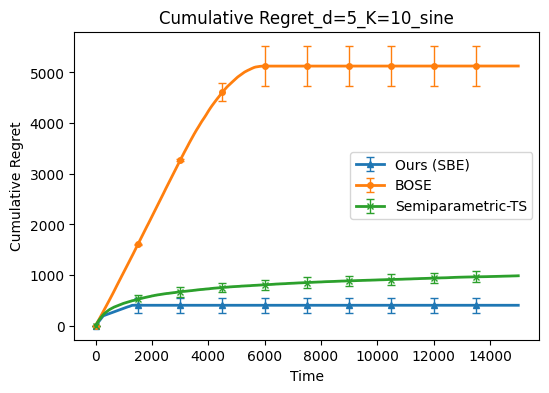

Comparison plot saved at: /content/drive/MyDrive/ODSP_Experiments/comparison_cumulative_regret_d=5_K=10_sine.pdf


In [ ]:
num_pulls_speed = T

steps = np.arange(1, T + 1)
freq = int(T / 10)

plt.figure(figsize=(6, 4))

# Plot the SBE results with error bars
plt.errorbar(steps, avg_reg, sd_reg, errorevery=freq, marker='^', markevery=freq, label='Ours (SBE)', markersize=4, linewidth=2, elinewidth=1, capsize=3)

# Plot the BOSE results with error bars
plt.errorbar(steps, avg_reg_bose, sd_reg_bose, errorevery=freq, marker='o', markevery=freq, label='BOSE', markersize=4, linewidth=2, elinewidth=1, capsize=3)

# Plot the TS algorithm results with error bars
plt.errorbar(steps, avg_reg_ts, sd_reg_ts, errorevery=freq, marker='x', markevery=freq, label='Semiparametric-TS', markersize=4, linewidth=2, elinewidth=1, capsize=3)

# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret_d=5_K=10_sine')
plt.legend()

# Save and display the plot
plot_filename_comparison = f'comparison_cumulative_regret_d={d}_K={K}_sine.pdf'
plot_path_comparison = os.path.join(output_dir, plot_filename_comparison)

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Save and display the plot
plt.savefig(plot_path_comparison)
plt.show()

print(f"Comparison plot saved at: {plot_path_comparison}")

# Regret Comparision (Sine Shift, d=20, K=30)

## Parameters

In [ ]:
# Parameters
K = 30
d = 20
np.random.seed(1)
contexts, theta = generate_fixed_theta_and_contexts(K, d)
sigma = 1
delta = 0.1
T = 30000 # total number of pulls
hyper =1
hyper_2 =1
# Generate random contexts on the sphere
np.random.seed(1)
X = contexts
theta_star = theta


In [ ]:
lambda_bose = 4* d*np.log(9*T) + 8*np.log(4*T/delta)
standard =  np.sqrt(lambda_bose)+ np.sqrt(d*np.log(1+ T/d) + np.log(T/delta))
gamma_bose = standard

## Run Ours (SBE)

In [ ]:
import numpy as np

# Set the seed for reproducibility.
# You can use any integer for the seed value.
np.random.seed(10)

num_simulations = 10
all_cumulative_regrets = []

for _ in range(num_simulations):
    # If the SBE function uses numpy's random number generator,
    # its results will now be deterministic.
    _, cumulative_regret_speed, _ = SBE(X, theta_star, sigma, delta, T)
    all_cumulative_regrets.append(cumulative_regret_speed)

# Convert the list of arrays into a 2D numpy array for easy manipulation.
# Pad shorter arrays to match the length of the longest one (T).
all_cumulative_regrets = np.array([np.pad(cr, (0, T - len(cr)), 'edge') for cr in all_cumulative_regrets])

# Calculate the average and standard deviation across all simulations.
avg_reg = all_cumulative_regrets.mean(axis=0)
sd_reg = all_cumulative_regrets.std(axis=0)

# Prepare variables for plotting.
steps = np.arange(1, T + 1)
# Set the frequency for plotting markers or error bars, for instance.
freq = int(T / 10)

In [ ]:
print(np.mean(avg_reg))

2677.6681432504142


## Run TS

In [ ]:
import numpy as np

# Set the random seed for reproducibility.
# Using the same seed ensures the same sequence of "random" numbers.
np.random.seed(10)

# Run the TS algorithm 10 times
num_simulations = 10
all_cumulative_regrets_ts = []
nu_values = [1]

for _ in range(num_simulations):
    # The results from ts_algorithm will now be the same in each run
    # if it relies on numpy's random number generation.
    cumulative_regret_ts, num_pulls_ts, best_nu = ts_algorithm(X, theta_star, sigma, delta, T, num_samples=3000, nu_values=nu_values)
    all_cumulative_regrets_ts.append(cumulative_regret_ts)

# Convert to numpy array for easy manipulation
# This pads each simulation's regret array to the same length T.
all_cumulative_regrets_ts = np.array([np.pad(cr, (0, T - len(cr)), 'edge') for cr in all_cumulative_regrets_ts])

# Calculate average and standard deviation across all simulations
avg_reg_ts = all_cumulative_regrets_ts.mean(axis=0)
sd_reg_ts = all_cumulative_regrets_ts.std(axis=0)


Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1
Trying nu = 1
Best nu: 1


In [ ]:
print(np.mean(avg_reg_ts))

9297.882228416545


## RUN BOSE

In [ ]:
import numpy as np

# Set the random seed for reproducibility.
# This ensures that any random processes within the bose_algorithm
# will produce the same results each time the script is run.
np.random.seed(10)

# Run the BOSE algorithm 10 times
num_simulations = 10
all_cumulative_regrets_bose = []

for _ in range(num_simulations):
    cumulative_regret_bose, _ = bose_algorithm(X, theta_star, sigma, delta, T)
    all_cumulative_regrets_bose.append(cumulative_regret_bose)

# Convert to numpy array for easy manipulation.
# This step pads each regret array to ensure they all have length T.
all_cumulative_regrets_bose = np.array([np.pad(cr, (0, T - len(cr)), 'edge') for cr in all_cumulative_regrets_bose])

# Calculate the average and standard deviation of the cumulative regret
# across all simulations.
avg_reg_bose = all_cumulative_regrets_bose.mean(axis=0)
sd_reg_bose = all_cumulative_regrets_bose.std(axis=0)

Time step: 100
Time step: 200
Time step: 300
Time step: 400
Time step: 500
Time step: 600
Time step: 700
Time step: 800
Time step: 900
Time step: 1000
Time step: 1100
Time step: 1200
Time step: 1300
Time step: 1400
Time step: 1500
Time step: 1600
Time step: 1700
Time step: 1800
Time step: 1900
Time step: 2000
Time step: 2100
Time step: 2200
Time step: 2300
Time step: 2400
Time step: 2500
Time step: 2600
Time step: 2700
Time step: 2800
Time step: 2900
Time step: 3000
Time step: 3100
Time step: 3200
Time step: 3300
Time step: 3400
Time step: 3500
Time step: 3600
Time step: 3700
Time step: 3800
Time step: 3900
Time step: 4000
Time step: 4100
Time step: 4200
Time step: 4300
Time step: 4400
Time step: 4500
Time step: 4600
Time step: 4700
Time step: 4800
Time step: 4900
Time step: 5000
Time step: 5100
Time step: 5200
Time step: 5300
Time step: 5400
Time step: 5500
Time step: 5600
Time step: 5700
Time step: 5800
Time step: 5900
Time step: 6000
Time step: 6100
Time step: 6200
Time step: 6300
T

In [ ]:
print(np.mean(avg_reg_bose))

14860.322194580911


## Plotting

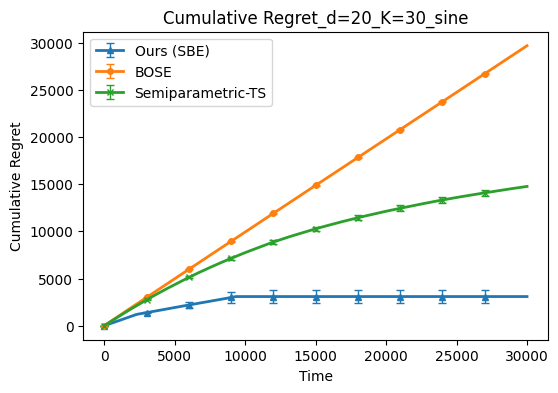

Comparison plot saved at: /content/drive/MyDrive/ODSP_Experiments/comparison_cumulative_regret_d=20_K=30_sine.pdf


In [ ]:
steps = np.arange(1, T + 1)
freq = int(T / 10)

plt.figure(figsize=(6, 4))

# Plot the SBE results with error bars
plt.errorbar(steps, avg_reg, sd_reg, errorevery=freq, marker='^', markevery=freq, label='Ours (SBE)', markersize=4, linewidth=2, elinewidth=1, capsize=3)

# Plot the BOSE results with error bars
plt.errorbar(steps, avg_reg_bose, sd_reg_bose, errorevery=freq, marker='o', markevery=freq, label='BOSE', markersize=4, linewidth=2, elinewidth=1, capsize=3)

# Plot the TS algorithm results with error bars
plt.errorbar(steps, avg_reg_ts, sd_reg_ts, errorevery=freq, marker='x', markevery=freq, label='Semiparametric-TS', markersize=4, linewidth=2, elinewidth=1, capsize=3)

# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret_d=20_K=30_sine')
plt.legend()

# Save and display the plot
plot_filename_comparison = f'comparison_cumulative_regret_d={d}_K={K}_sine.pdf'
plot_path_comparison = os.path.join(output_dir, plot_filename_comparison)

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Save and display the plot
plt.savefig(plot_path_comparison)
plt.show()

print(f"Comparison plot saved at: {plot_path_comparison}")

# PAC (Investigating Maximum Error Among Arms)

## d=5, K=30

In [ ]:
import os

# Assuming generate_fixed_theta_and_contexts is defined elsewhere
# Parameters
K = 30
d = 5
np.random.seed(1)
contexts, theta = generate_fixed_theta_and_contexts(K, d)  # Generate contexts and theta
sigma = 1
beta = 2
delta = 0.1
T = 10000  # Total number of pulls
hyper = 1
hyper_2 = 1

# Tuning parameters
theta_update_freq = 100  # Update theta_hat every 10 iterations
errorbar_freq = 100 # Plot error bars every 100 iterations

# Generate random contexts on the sphere
np.random.seed(1)
X = contexts  # Using generated contexts
theta_star = theta  # Using generated theta

def best_arm_identification(X, theta_star, sigma, beta, max_iter=10000, theta_update_freq=10):
    K, d = X.shape
    pi = DEO(X)  # Assuming speed(X) is defined elsewhere
    X_mean = np.sum([pi[j] * X[j] for j in range(K)], axis=0)
    estimation_errors = []
    y_samples = []
    X_samples = []
    theta_hat = np.zeros(d)  # Initialize theta_hat

    for t in range(max_iter):
        i = np.random.choice(K, p=pi)
        reward = X[i].dot(theta_star) + np.random.normal(0, sigma) + 1 + f(t)

        # Center the context
        X_centered = X[i] - X_mean

        X_samples.append(X_centered)
        y_samples.append(reward)

        # Update theta_hat only every theta_update_freq iterations
        if (t + 1) % theta_update_freq == 0:
            X_samples_array = np.array(X_samples)
            y_samples_array = np.array(y_samples)
            V = X_samples_array.T @ X_samples_array + beta * np.log(t)* np.eye(d)
            b = X_samples_array.T @ y_samples_array
            theta_hat = np.linalg.solve(V, b)

        # Calculate and store the maximum absolute estimation error
        estimation_error = np.max(np.abs((X - X[0]) @ (theta_hat - theta_star)))
        estimation_errors.append(estimation_error*np.sqrt(t))

    return theta_hat, estimation_errors

# Collect estimation errors over multiple runs
num_runs = 10  # Run 10 times
all_estimation_errors = np.zeros((num_runs, T))

for run in range(num_runs):
    _, estimation_errors = best_arm_identification(X, theta_star, sigma, beta, max_iter=T, theta_update_freq=theta_update_freq)
    all_estimation_errors[run, :] = estimation_errors

# Calculate mean and standard deviation
mean_errors = np.mean(all_estimation_errors, axis=0)
std_errors = np.std(all_estimation_errors, axis=0)

# Generate the steps for x-axis
steps = np.arange(T)

# Frequency for error bars (errorbar_freq)
error_every = errorbar_freq

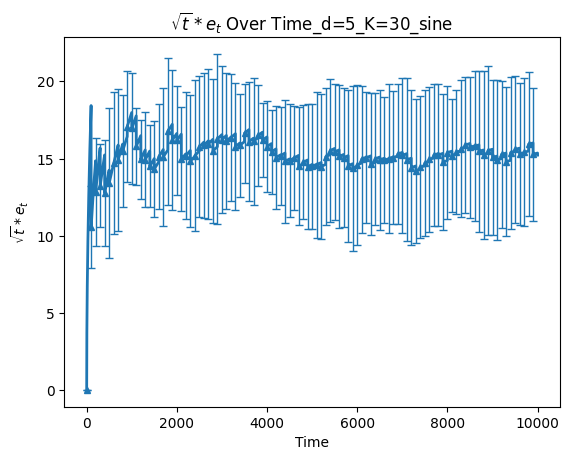

Plot saved at: /content/drive/MyDrive/ODSP_Experiments/estimation_error_d=5_K=30_sine.pdf


In [ ]:
# Plot the error bars every errorbar_freq iterations
plt.errorbar(steps, mean_errors, yerr=std_errors, errorevery=error_every, marker='^', markevery=error_every,
             label='Our PE-SVD', markersize=4, linewidth=2, elinewidth=1, capsize=3)
plt.xlabel('Time')
plt.ylabel(r'$\sqrt{t}* e_t$')
plt.title('$\sqrt{t}*e_t$ Over Time_d=5_K=30_sine')

# Save the plot
plot_filename = f'estimation_error_d={d}_K={K}_sine.pdf'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

print(f"Plot saved at: {plot_path}")


## d=30, K=30

In [ ]:
import os

# Assuming generate_fixed_theta_and_contexts is defined elsewhere
# Parameters
K = 30
d = 30
np.random.seed(1)
contexts, theta = generate_fixed_theta_and_contexts(K, d)  # Generate contexts and theta
sigma = 1
beta = 2
delta = 0.1
T = 10000  # Total number of pulls
hyper = 1
hyper_2 = 1

# Tuning parameters
theta_update_freq = 100  # Update theta_hat every 10 iterations
errorbar_freq = 100 # Plot error bars every 100 iterations

# Generate random contexts on the sphere
np.random.seed(1)
X = contexts  # Using generated contexts
theta_star = theta  # Using generated theta

def best_arm_identification(X, theta_star, sigma, beta, max_iter=10000, theta_update_freq=10):
    K, d = X.shape
    pi = DEO(X)  # Assuming speed(X) is defined elsewhere
    X_mean = np.sum([pi[j] * X[j] for j in range(K)], axis=0)
    estimation_errors = []
    y_samples = []
    X_samples = []
    theta_hat = np.zeros(d)  # Initialize theta_hat

    for t in range(max_iter):
        i = np.random.choice(K, p=pi)
        reward = X[i].dot(theta_star) + np.random.normal(0, sigma) + 1 + f(t)

        # Center the context
        X_centered = X[i] - X_mean

        X_samples.append(X_centered)
        y_samples.append(reward)

        # Update theta_hat only every theta_update_freq iterations
        if (t + 1) % theta_update_freq == 0:
            X_samples_array = np.array(X_samples)
            y_samples_array = np.array(y_samples)
            V = X_samples_array.T @ X_samples_array + beta * np.log(t)* np.eye(d)
            b = X_samples_array.T @ y_samples_array
            theta_hat = np.linalg.solve(V, b)

        # Calculate and store the maximum absolute estimation error
        estimation_error = np.max(np.abs((X - X[0]) @ (theta_hat - theta_star)))
        estimation_errors.append(estimation_error*np.sqrt(t))

    return theta_hat, estimation_errors

# Collect estimation errors over multiple runs
num_runs = 10  # Run 10 times
all_estimation_errors = np.zeros((num_runs, T))

for run in range(num_runs):
    _, estimation_errors = best_arm_identification(X, theta_star, sigma, beta, max_iter=T, theta_update_freq=theta_update_freq)
    all_estimation_errors[run, :] = estimation_errors

# Calculate mean and standard deviation
mean_errors = np.mean(all_estimation_errors, axis=0)
std_errors = np.std(all_estimation_errors, axis=0)

# Generate the steps for x-axis
steps = np.arange(T)

# Frequency for error bars (errorbar_freq)
error_every = errorbar_freq


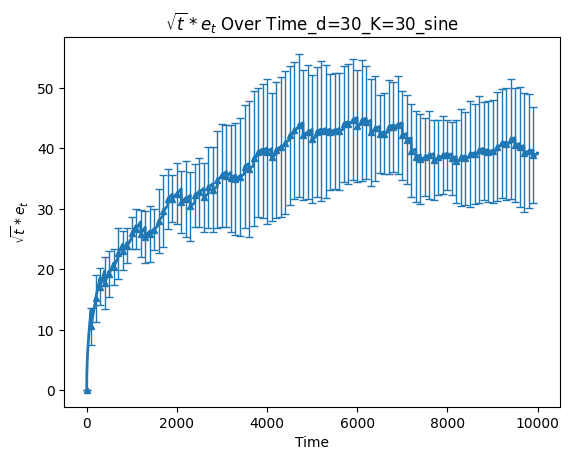

Plot saved at: /content/drive/MyDrive/ODSP_Experiments/estimation_error_d=30_K=30_sine.pdf


In [ ]:
# Plot the error bars every errorbar_freq iterations
plt.errorbar(steps, mean_errors, yerr=std_errors, errorevery=error_every, marker='^', markevery=error_every,
             label='Our PE-SVD', markersize=4, linewidth=2, elinewidth=1, capsize=3)
plt.xlabel('Time')
plt.ylabel(r'$\sqrt{t}* e_t$')
plt.title('$\sqrt{t}*e_t$ Over Time_d=30_K=30_sine')

# Save the plot
plot_filename = f'estimation_error_d={d}_K={K}_sine.pdf'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

print(f"Plot saved at: {plot_path}")